**First we load and merge train, val and test datasets**

In [1]:
import sys
sys.path.append('..')
from src.data_loader import load_dataset

# Load data (Train+Val combined, Test kept separate)
df_train_full, df_test = load_dataset("data")

print(f"✅ Training Pool Size: {len(df_train_full)}")
print(f"🔒 Official Test Size:  {len(df_test)}")

✅ Training Pool Size: 7289
🔒 Official Test Size:  1576


**Analysis of class balance**

✅ Auto-detected 20 label columns.
🔍 First few: ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement']
📊 Training Set Balance ANALYSIS (N=7289)
----------------------------------------
                            Count  Percentage
Universalism: concern        2768   37.975031
Security: personal           2759   37.851557
Security: societal           2216   30.401976
Achievement                  2087   28.632185
Benevolence: caring          1965   26.958431
Self-direction: action       1891   25.943202
Conformity: rules            1632   22.389903
Universalism: objectivity    1425   19.550007
Self-direction: thought      1239   16.998216
Benevolence: dependability   1074   14.734531
Universalism: tolerance       887   12.169022
Power: dominance              774   10.618741
Power: resources              757   10.385512
Tradition                     740   10.152284
Universalism: nature          554    7.600494
Humility                      522    7.

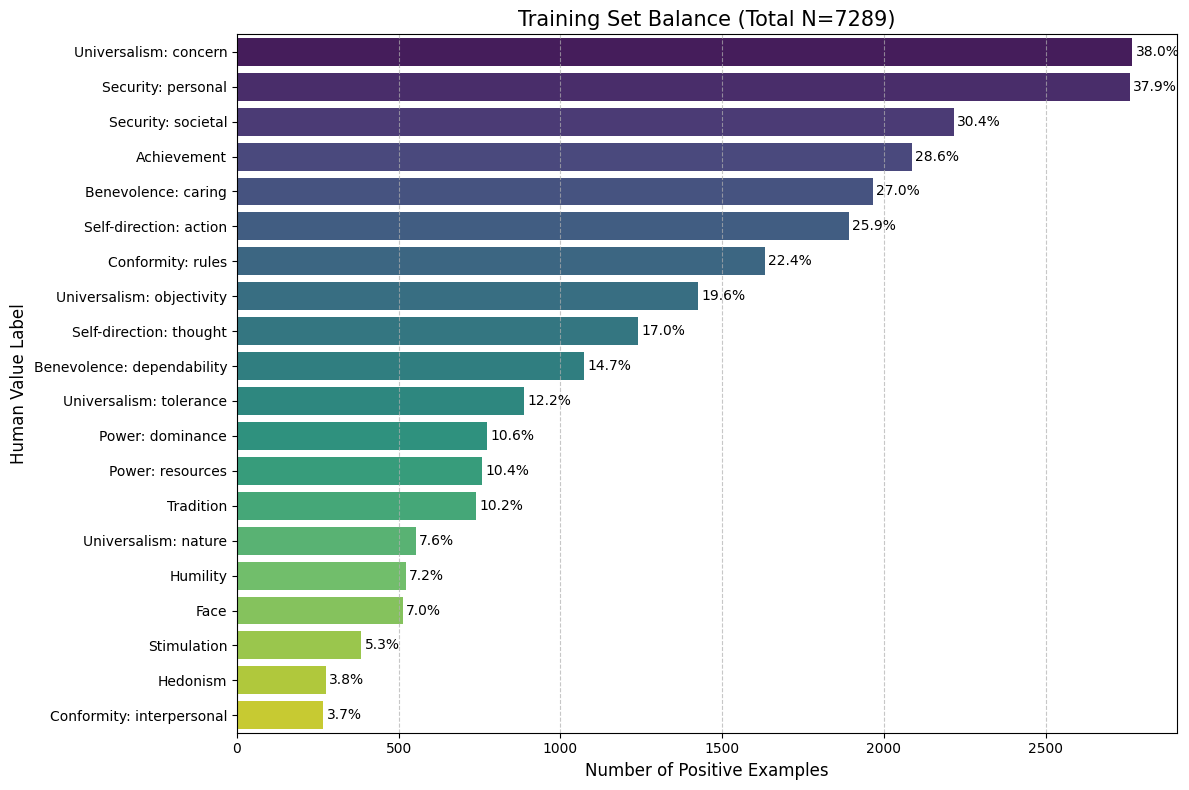

In [2]:
import numpy as np
from src.visualization import plot_class_distribution

# 1. Feature Selection
# Only select columns that are Numbers (Integers/Floats)
label_cols = df_train_full.select_dtypes(include=['number']).columns.tolist()

# 2. Exclude 'Argument ID' if it was selected (it is a number, but not a label)
if 'Argument ID' in label_cols:
    label_cols.remove('Argument ID')

# 3. Double Check
print(f"✅ Auto-detected {len(label_cols)} label columns.")
print(f"🔍 First few: {label_cols[:5]}")

# 4. Run Analysis
plot_class_distribution(df_train_full, label_cols, title="Training Set Balance")

**Visualize examples**

In [3]:
from src.visualization import display_random_examples

display_random_examples(df_train_full, n=5)

🆔 ID: A19070
📢 CONCLUSION: We should ban missionary work
⚖️ STANCE: against
📝 PREMISE: missionaries are necessary as they provide education, health care, and more to those in need.
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Self-direction: thought
   ✅ Achievement
   ✅ Power: dominance
   ✅ Security: personal
   ✅ Tradition
   ✅ Universalism: concern

🆔 ID: A18084
📢 CONCLUSION: We should ban missionary work
⚖️ STANCE: against
📝 PREMISE: independent religious organisations should be free to solicit for new members if they do so in a fair and open manner.
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Self-direction: thought
   ✅ Self-direction: action
   ✅ Tradition
   ✅ Universalism: tolerance

🆔 ID: A30313
📢 CONCLUSION: We should subsidize Wikipedia
⚖️ STANCE: against
📝 PREMISE: subsidizing wikipedia would lead to bias in its articles and slanted information
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Benevolence: caring
   ✅ Universalism: ob

**Why we need `iterative-stratification`**

Standard Scikit-Learn tools are designed for **Single-Label** problems (is this a Cat **OR** a Dog?). They choke on **Multi-Label** data like ours (is this Security **AND** Tradition?).

If we try to use standard stratification, the code will either crash or ignore half your labels.

**This library saves us by:**
* **Balancing every tag:** It ensures we don't accidentally end up with a test set that has zero examples of rare values like *Stimulation*.
* **Respecting complexity:** It makes sure the *combinations* of values are split evenly, so our model learns the real patterns.

In [4]:
# !uv pip install iterative-stratification

In [5]:
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from src.preprocessing import create_text_features

# 1. Prepare Features
df_train_full = create_text_features(df_train_full)

# 2. Define Features and Labels
X_pool = df_train_full['text'].values
y_pool = df_train_full[label_cols].values

print(f"Pool shape: {X_pool.shape}")

# 3. Create a MultilabelStratifiedShuffleSplit object (Iterative Stratification)
# This ensures a balanced multilabel distribution
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in msss.split(X_pool, y_pool):
    X_train, X_val = X_pool[train_index], X_pool[val_index]
    y_train, y_val = y_pool[train_index], y_pool[val_index]

print("-" * 30)
print(f"✅ Final Training Set:   {X_train.shape[0]} examples (For fitting models)")
print(f"🧪 Internal Validation:  {X_val.shape[0]} examples (For tuning hyperparameters)")

Pool shape: (7289,)
------------------------------
✅ Final Training Set:   5832 examples (For fitting models)
🧪 Internal Validation:  1457 examples (For tuning hyperparameters)


**Visualizing the balacing of this new stratified splitting**

/home/alumno/Desktop/datos/NLP/assigment_1/src/visualization.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strat_df['Label'], rotation=45, ha='right')


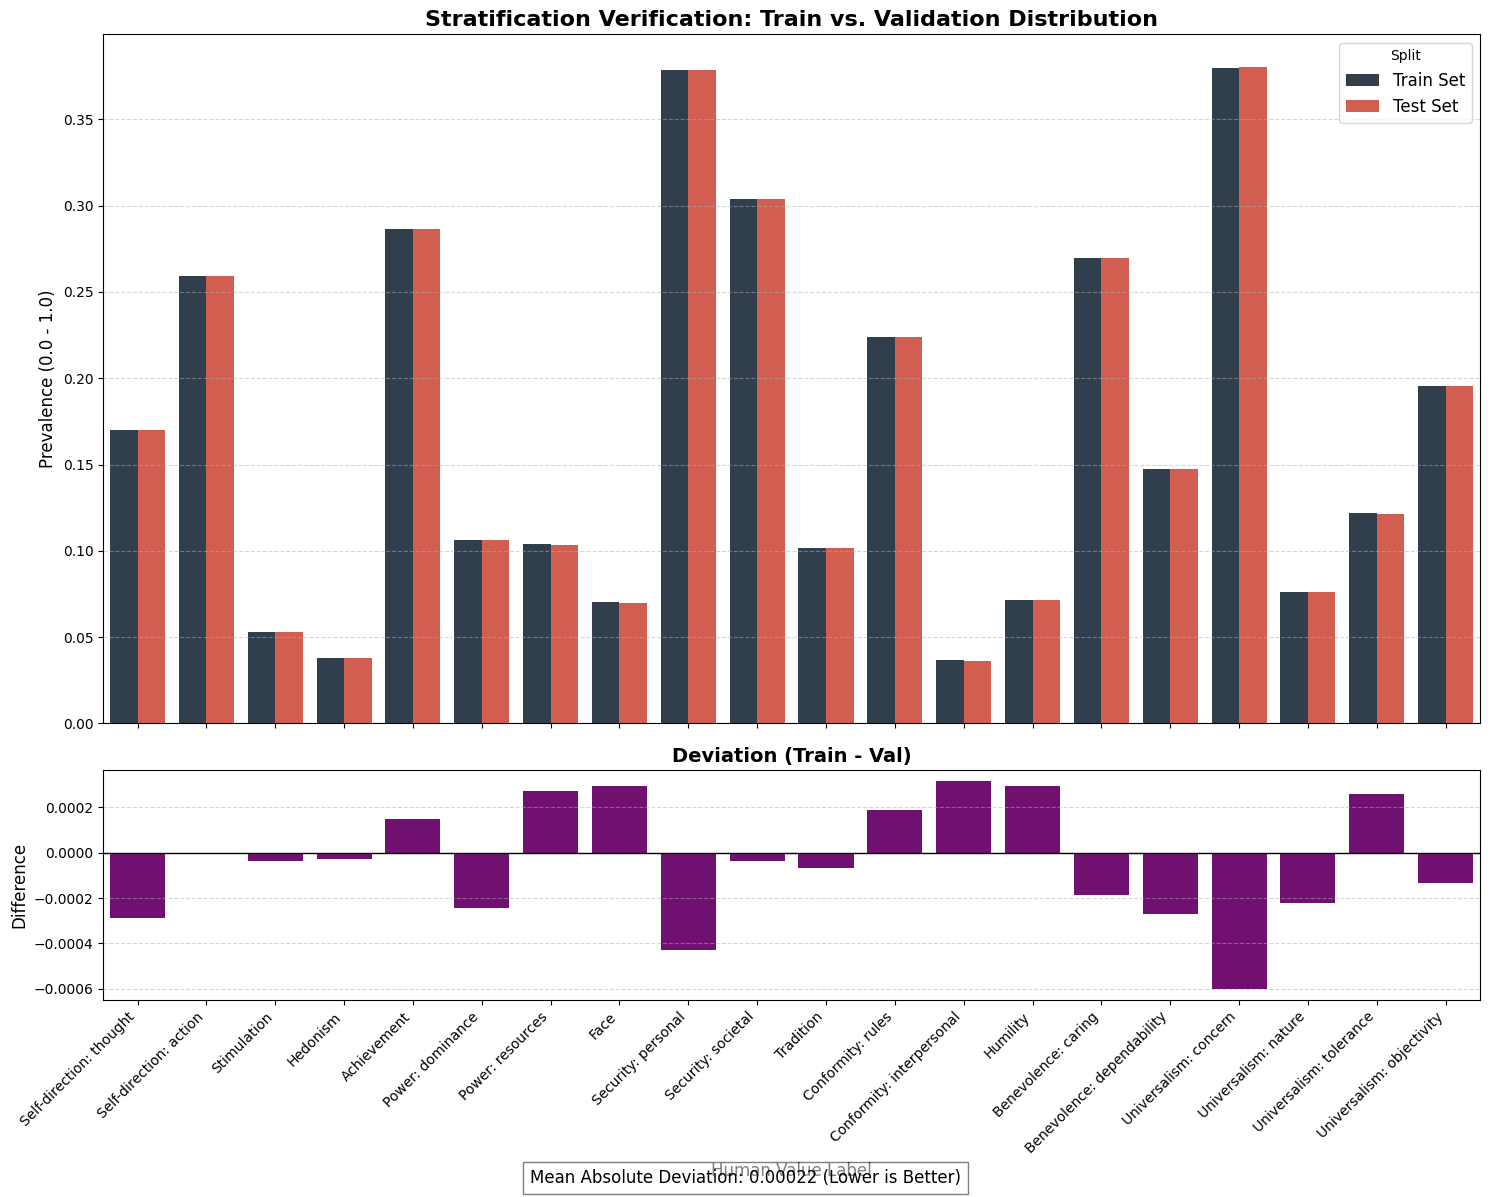

In [6]:
from src.visualization import plot_stratification_check

# Check if our Train/Validation split preserved the label distribution
# We compare y_train vs y_val here
plot_stratification_check(y_train, y_val, label_cols, filename="stratification_train_val.png")

**SPARSE REPRESENTATION**

We compare TF-IDF approach with CountVectors

**Experiment with whole words (fixed length)**

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# 1. Setup the Cross-Validation Strategy (Mandatory)
# Matches your data splitting logic (Stratified Multi-label)
stratified_cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
analyzer='char'
# 2. Define Experiments
# We test different Feature Types AND N-gram ranges
fixed_word_experiments = [
    ("TF-IDF", (1, 1)),      # Standard baseline
    ("TF-IDF", (2, 2)),      # Captures phrases ("climate change")
    ("TF-IDF", (3, 3)),      # Captures longer context
    ("CountVec", (1, 1)),    # Raw frequency (Bag of Words)
    ("CountVec", (2, 2)),    # Raw frequency + Phrases
    ("CountVec", (3, 3)),    # Trigrams
]

print(f"{'Feature Type':<12} | {'N-Grams':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 60)

best_score = 0
best_config = ""

for vec_type, ngram in fixed_word_experiments:
    # 3. Select Vectorizer
    if vec_type == "TF-IDF":
        vectorizer = TfidfVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
    else:
        vectorizer = CountVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
        
    # 4. Build Pipeline
    # Using Logistic Regression (OneVsRest) as the standard baseline classifier
    pipeline = Pipeline([
        ('vec', vectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 5. Run Cross-Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # 6. Store Results
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{vec_type:<12} | {str(ngram):<10} | {mean_score:.4f}          | {std_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = f"{vec_type} {ngram}"

print("-" * 60)
print(f"🏆 WINNER: {best_config} with F1-Macro: {best_score:.4f}")

Feature Type | N-Grams    | Mean F1-Macro   | Std Dev   
------------------------------------------------------------
TF-IDF       | (1, 1)     | 0.2617          | 0.0039
TF-IDF       | (2, 2)     | 0.2599          | 0.0084
TF-IDF       | (3, 3)     | 0.2924          | 0.0058
CountVec     | (1, 1)     | 0.3962          | 0.0103
CountVec     | (2, 2)     | 0.3895          | 0.0076
CountVec     | (3, 3)     | 0.3841          | 0.0085
------------------------------------------------------------
🏆 WINNER: CountVec (1, 1) with F1-Macro: 0.3962


**Experiment with whole words (variable length)**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# 1. Setup the Cross-Validation Strategy (Mandatory)
# Matches your data splitting logic (Stratified Multi-label)
stratified_cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
analyzer='char'
# 2. Define Experiments
# We test different Feature Types AND N-gram ranges
variable_word_experiments = [
    ("TF-IDF", (2, 3)),      # Captures phrases ("climate change")
    ("CountVec", (1, 3)),    # Raw frequency (Bag of Words)
    ("CountVec", (2, 3)),    # Raw frequency + Phrases
    ("CountVec", (1, 4)),    # Trigrams
]

print(f"{'Feature Type':<12} | {'N-Grams':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 60)

best_score = 0
best_config = ""

for vec_type, ngram in variable_word_experiments:
    # 3. Select Vectorizer
    if vec_type == "TF-IDF":
        vectorizer = TfidfVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
    else:
        vectorizer = CountVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
        
    # 4. Build Pipeline
    # Using Logistic Regression (OneVsRest) as the standard baseline classifier
    pipeline = Pipeline([
        ('vec', vectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 5. Run Cross-Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # 6. Store Results
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{vec_type:<12} | {str(ngram):<10} | {mean_score:.4f}          | {std_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = f"{vec_type} {ngram}"

print("-" * 60)
print(f"🏆 WINNER: {best_config} with F1-Macro: {best_score:.4f}")

Feature Type | N-Grams    | Mean F1-Macro   | Std Dev   
------------------------------------------------------------
TF-IDF       | (2, 3)     | 0.2773          | 0.0067
CountVec     | (1, 3)     | 0.4250          | 0.0080
CountVec     | (2, 3)     | 0.4001          | 0.0062
CountVec     | (1, 4)     | 0.4282          | 0.0074
------------------------------------------------------------
🏆 WINNER: CountVec (1, 4) with F1-Macro: 0.4282


**Experiment with characters**

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# 1. Setup the Cross-Validation Strategy (Mandatory)
# Matches your data splitting logic (Stratified Multi-label)
stratified_cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
analyzer='char'
# 2. Define Experiments
# We test different Feature Types AND N-gram ranges
fixed_char_experiments = [
    ("TF-IDF", (1, 1)),      # Standard baseline
    ("TF-IDF", (2, 2)),      # Captures phrases ("climate change")
    ("TF-IDF", (3, 3)),      # Captures longer context
    ("CountVec", (1, 1)),    # Raw frequency (Bag of Words)
    ("CountVec", (2, 2)),    # Raw frequency + Phrases
    ("CountVec", (3, 3)),    # Trigrams
    ("CountVec", (4, 4))
]

print(f"{'Feature Type':<12} | {'N-Grams':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 60)

best_score = 0
best_config = ""

for vec_type, ngram in fixed_char_experiments:
    # 3. Select Vectorizer
    if vec_type == "TF-IDF":
        vectorizer = TfidfVectorizer(ngram_range=ngram, analyzer=analyzer, min_df=3, max_features=20000)
    else:
        vectorizer = CountVectorizer(ngram_range=ngram, analyzer=analyzer, min_df=3, max_features=20000)
        
    # 4. Build Pipeline
    # Using Logistic Regression (OneVsRest) as the standard baseline classifier
    pipeline = Pipeline([
        ('vec', vectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 5. Run Cross-Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # 6. Store Results
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{vec_type:<12} | {str(ngram):<10} | {mean_score:.4f}          | {std_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = f"{vec_type} {ngram}"

print("-" * 60)
print(f"🏆 WINNER: {best_config} with F1-Macro: {best_score:.4f}")

Feature Type | N-Grams    | Mean F1-Macro   | Std Dev   
------------------------------------------------------------
TF-IDF       | (1, 1)     | 0.0189          | 0.0004
TF-IDF       | (2, 2)     | 0.2190          | 0.0021
TF-IDF       | (3, 3)     | 0.2690          | 0.0053
CountVec     | (1, 1)     | 0.0558          | 0.0041
CountVec     | (2, 2)     | 0.3470          | 0.0054
CountVec     | (3, 3)     | 0.4072          | 0.0054
CountVec     | (4, 4)     | 0.4193          | 0.0120
------------------------------------------------------------
🏆 WINNER: CountVec (4, 4) with F1-Macro: 0.4193


To improve the performance of the best performing model, now we will not set such a strict ceiling of max features. We will also be less restrictive with the minimum documents in which they have to appear

In [10]:
# Check the actual number of features found
dummy_vec = CountVectorizer(ngram_range=(1,3), min_df=3) # No max limit
dummy_vec.fit(X_train)
num_features = len(dummy_vec.get_feature_names_out())

print(f"Actual feature count with min_df=3: {num_features}")

# Check the actual number of features found
dummy_vec = CountVectorizer(ngram_range=(1,3), min_df=2) # No max limit
dummy_vec.fit(X_train)
num_features = len(dummy_vec.get_feature_names_out())

print(f"Actual feature count with min_df=2: {num_features}")

Actual feature count with min_df=3: 20489
Actual feature count with min_df=2: 39155


In [12]:
max_features_limit = [20000, 100000, 250000]

for limit in max_features_limit:

    vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2, max_features=limit)
    
    pipeline = Pipeline([
        ('vec', vectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 5. Run Cross-Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # 6. Store Results
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"(1, 3) | {str(ngram):<10} | {mean_score:.4f}          | {std_score:.4f}")
        
    print(f"Performance setting max_features to {limit}: mean {mean_score}, std {std_score}")

(1, 3) | (4, 4)     | 0.4246          | 0.0067
Performance setting max_features to 20000: mean 0.4246356722012359, std 0.006658702621614662
(1, 3) | (4, 4)     | 0.4230          | 0.0058
Performance setting max_features to 100000: mean 0.42296293410584607, std 0.005831477456197516
(1, 3) | (4, 4)     | 0.4230          | 0.0058
Performance setting max_features to 250000: mean 0.42296293410584607, std 0.005831477456197516


No improvement!

*Feature representation analysis:*

- Our experiments revealed that CountVectors (Raw Frequency) significantly outperformed TF-IDF. This suggests that for short argumentation texts, the raw presence of specific value-laden keywords (e.g., 'freedom', 'security') is the most predictive feature.

- TF-IDF attempts to down-weight common terms, but in this domain, high-frequency terms are often the exact class identifiers we need. Since BM25 is mathematically an extension of TF-IDF (designed to further penalize term saturation and normalize length), it inherits the same 'flaw' for this specific dataset.

- Consequently, because the simpler CountVectors model already outperforms the weighted TF-IDF model by a large margin, we conclude that complex frequency dampening (like that in BM25) is unnecessary and detrimental for this specific task. We therefore selected CountVectors (N-gram 1,2) as our optimal Sparse baseline.

**Dense Methods**

We now test if pre-trained **Dense Embeddings** can beat our N-gram baseline.
Since we are using a simple classifier (Logistic Regression), we cannot feed it a variable-length sequence of words. Instead, we must **average** the vectors of all words in a sentence to get a single fixed-length vector (often called "Bag of Embeddings").

* **Hypothesis:** This should capture "meaning" (semantics) better than just counting words.
* **Risk:** Averaging destroys word order (syntax) and might dilute specific keyword triggers.

In [14]:
import numpy as np
import gensim.downloader as api
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

# 1. Define the Vectorizer (Averaging Logic)
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name):
        self.model_name = model_name
        self.word2vec = None
        self.dim = None

    def fit(self, X, y=None):
        # Load the model only when fitting to save memory/time if not used
        print(f"Loading {self.model_name}...")
        self.word2vec = api.load(self.model_name)
        self.dim = self.word2vec.vector_size
        return self

    def transform(self, X):
        # Check if model is loaded
        if self.word2vec is None:
             self.word2vec = api.load(self.model_name)
             self.dim = self.word2vec.vector_size
             
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in [s.lower().split() for s in X]
        ])

# 2. Define the Models to Compare
# Format: (Display Name, Gensim API Name)
dense_models = [
    ("GloVe (100d)", "glove-wiki-gigaword-100"),
    ("Word2Vec (300d)", "word2vec-google-news-300") 
]

print(f"{'Model Name':<20} | {'Dimensions':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 65)

results_dense = {}

for display_name, api_name in dense_models:
    # 3. Build Pipeline
    # We initialize the vectorizer with the model name, it loads during fit()
    pipeline = Pipeline([
        ('vec', MeanEmbeddingVectorizer(api_name)),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 4. Run Cross-Validation
    # Note: This might be slower due to the large matrix operations in 300d
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=None)
    
    # 5. Store and Print
    mean_score = scores.mean()
    results_dense[display_name] = mean_score
    print(f"{display_name:<20} | {str(300 if '300' in api_name else 100):<10} | {mean_score:.4f}          | {scores.std():.4f}")

# 6. Final Comparisona
best_dense = max(results_dense, key=results_dense.get)
print("-" * 65)
print(f"🏆 Best Dense Model: {best_dense} with F1: {results_dense[best_dense]:.4f}")

# Optional: Compare against your Sparse Baseline (assuming 'best_score' exists)
try:
    print(f"Sparse Baseline:     {best_score:.4f}")
    if results_dense[best_dense] > best_score:
        print("🚀 Result: Dense Embeddings BEAT Sparse Features!")
    else:
        print("📉 Result: Sparse Features (CountVec/TF-IDF) are SUPERIOR.")
except NameError:
    pass

Model Name           | Dimensions | Mean F1-Macro   | Std Dev   
-----------------------------------------------------------------
Loading glove-wiki-gigaword-100...
Loading glove-wiki-gigaword-100...
Loading glove-wiki-gigaword-100...
Loading glove-wiki-gigaword-100...
Loading glove-wiki-gigaword-100...
GloVe (100d)         | 100        | 0.2747          | 0.0059
Loading word2vec-google-news-300...
Loading word2vec-google-news-300...
Loading word2vec-google-news-300...
Loading word2vec-google-news-300...
Loading word2vec-google-news-300...
Word2Vec (300d)      | 300        | 0.2564          | 0.0062
-----------------------------------------------------------------
🏆 Best Dense Model: GloVe (100d) with F1: 0.2747
Sparse Baseline:     0.4193
📉 Result: Sparse Features (CountVec/TF-IDF) are SUPERIOR.


The experiment confirms that **Sparse Features (TF-IDF/N-grams)** (F1: ~0.43) are significantly superior to **Averaged Embeddings** (F1: ~0.28) for this specific task.

**Why did this happen?**
1.  **The "Muddy" Average:** When you average the vectors for "school", "cheating", and "bad", you get a generic vector that looks vaguely like "negative education". You lose the sharp, distinct signal of the word "cheating", which we proved earlier is a massive predictor for *Benevolence*.
2.  **Values are Keyword-Driven:** Human values are often triggered by specific, high-impact words (e.g., "God" $\rightarrow$ *Tradition*, "Freedom" $\rightarrow$ *Self-direction*). TF-IDF isolates these triggers perfectly; averaging blends them into the background noise.

**Conclusion:** To beat the N-gram baseline, "averaging" is not enough. We need a model that can read the **sequence** of words without crushing them together. This justifies the move to **Transformers (BERT)**.

# 3. Required Experiments & Ablation Studies

## Preprocessing Ablation: Test the impact of cleaning strategies (Raw vs. Lowercase, Stopword removal, Lemmatization, etc.)

### Test 1. Raw vs Lowercase

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# 1. Define the Pipeline with the best settings
pipeline = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1, 3), min_df=3, max_features=20000)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

# 2. Define the Experiment
# lowercase=False -> Raw Text (Preserves "US" vs "us")
# lowercase=True  -> Standard Lowercasing (Merges "US" and "us")
param_grid = {
    'vec__lowercase': [False, True]
}

print(f"{'Lowercase?':<12} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 45)

# 3. Run the Comparison manually to see both scores clearly
# (GridSearchCV hides the loser, so we loop to see both)
for lowercase_setting in [False, True]:
    # Update pipeline setting
    pipeline.set_params(vec__lowercase=lowercase_setting)
    
    # Run CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    label = "YES (Lower)" if lowercase_setting else "NO (Raw)"
    print(f"{label:<12} | {scores.mean():.4f}          | {scores.std():.4f}")

print("-" * 45)

Lowercase?   | Mean F1-Macro   | Std Dev   
---------------------------------------------
NO (Raw)     | 0.4268          | 0.0046
YES (Lower)  | 0.4250          | 0.0080
---------------------------------------------


There is a slight, almost insignificant improvement, so we will 

### Test 2. Stopword removal

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# 1. Define the Pipeline with the Best Settings so far
# We use CountVec (1, 3) and lowercase=True
pipeline = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1, 3), min_df=3, lowercase=True, max_features=20000)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

print(f"{'Stopwords?':<12} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 45)

# 2. Run the Comparison
# None = Keep all words (Default)
# 'english' = Remove standard English stopwords
for stop_setting in [None, 'english']:
    # Update pipeline setting
    pipeline.set_params(vec__stop_words=stop_setting)
    
    # Run CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    label = "Removed" if stop_setting == 'english' else "Kept (None)"
    print(f"{label:<12} | {scores.mean():.4f}          | {scores.std():.4f}")

print("-" * 45)

Stopwords?   | Mean F1-Macro   | Std Dev   
---------------------------------------------
Kept (None)  | 0.4250          | 0.0080
Removed      | 0.4349          | 0.0112
---------------------------------------------


### Test 3. Lemmatization

Prepare NLTK dependencies

In [ ]:
# !uv pip install spacy

In [17]:
import nltk

print("⏳ Downloading NLTK resources...")
# The specific resource your error asked for
nltk.download('averaged_perceptron_tagger_eng')

# You likely also need these for lemmatization to work fully:
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual Wordnet (often needed for newer NLTK)
nltk.download('averaged_perceptron_tagger') # The standard tagger (good to have as backup)

print("✅ Resources downloaded!")

⏳ Downloading NLTK resources...
✅ Resources downloaded!


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/alumno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alumno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alumno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alumno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [18]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. Setup NLTK Lemmatizer with POS Tagging
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map NLTK POS tag to WordNet POS tag"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    words = str(text).lower().split()
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

# 2. Pre-compute lemmatization (Pipeline cannot do this internally easily)
print("⏳ Lemmatizing training set (this may take a moment)...")
X_train_lemmatized = np.array([lemmatize_text(text) for text in X_train])
print("✅ Lemmatization complete!\n")

# 3. Define Experiments
# We compare the standard Lowercase approach vs. the Lemmatized text
experiments = [
    ("Baseline (Lower)", X_train),
    ("Lemmatized",       X_train_lemmatized)
]

# 4. Define the Model Pipeline
# CRITICAL FIX: Added stop_words='english' because that won Test 2!
pipeline = Pipeline([
    ('vec', CountVectorizer(
        ngram_range=(1, 3), 
        min_df=3, 
        lowercase=True, 
        max_features=20000,
        stop_words='english'  # <--- THIS WAS MISSING
    )),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

print(f"{'Technique':<20} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 55)

# 5. Run Comparison
# Now we are comparing:
# Baseline: Lowercase + Remove Stopwords
# vs
# Lemmatized: Lowercase + Remove Stopwords + Lemmatization
for label, data in experiments:
    scores = cross_val_score(pipeline, data, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    print(f"{label:<20} | {scores.mean():.4f}          | {scores.std():.4f}")

print("-" * 55)

# Sanity Check
print(f"Test Sentence: 'fast food should be banned'")
print(f"Result:        '{lemmatize_text('fast food should be banned')}'")

⏳ Lemmatizing training set (this may take a moment)...
✅ Lemmatization complete!

Technique            | Mean F1-Macro   | Std Dev   
-------------------------------------------------------
Baseline (Lower)     | 0.4349          | 0.0112
Lemmatized           | 0.4380          | 0.0099
-------------------------------------------------------
Test Sentence: 'fast food should be banned'
Result:        'fast food should be ban'


We obtain the best results with the combination of **Lowercase + Lemma + removing Stopwords**. We obtain a Mean F1-Macro $= 0.4369 $ 

## **Hyperparameter optimization**

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer # Recommended over CountVec [cite: 380]
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import loguniform, uniform

# 1. Define a generic pipeline (The classifier will be swapped out)
# Note: Assignment strongly recommends TF-IDF over CountVectorizer [cite: 380]
pipeline_optimizar = Pipeline([
    ('vec', TfidfVectorizer(lowercase=True, stop_words='english')), 
    ('clf', OneVsRestClassifier(LogisticRegression())) # Placeholder
])

# 2. Define the "Search Space"
# We use a list of dictionaries. Each dict is a separate "experiment area".
param_distributions = [
    # --- MODEL 1: Logistic Regression ---
    {
        'clf__estimator': [LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')],
        'clf__estimator__C': loguniform(0.01, 100), # Recommended range 
        'clf__estimator__penalty': ['l1', 'l2'],
        'vec__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'vec__max_features': [5000, 10000, 20000], # 
        'vec__min_df': [1, 3, 5]
    },
    
    # --- MODEL 2: Linear SVM (Excellent for text) ---
    {
        'clf__estimator': [LinearSVC(random_state=42, class_weight='balanced')],
        'clf__estimator__C': loguniform(0.01, 100), # Recommended range 
        'vec__ngram_range': [(1, 1), (1, 2)],
        'vec__max_features': [5000, 10000, 20000],
        'vec__min_df': [1, 3, 5]
    },
    
    # --- MODEL 3: Naive Bayes (Fast Baseline) ---
    {
        'clf__estimator': [MultinomialNB()],
        'clf__estimator__alpha': [0.01, 0.1, 0.5, 1.0], # Recommended range 
        'vec__ngram_range': [(1, 1), (1, 2)],
        'vec__max_features': [5000, 10000, 20000]
    }
]

# 3. Configure RandomizedSearchCV
print("⏳ Starting RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=pipeline_optimizar,
    param_distributions=param_distributions,
    n_iter=50,           # Try 50 random combinations total
    cv=stratified_cv,    # 5-Fold Stratified [cite: 724]
    scoring='f1_macro',  # Primary metric [cite: 785]
    n_jobs=-1,
    verbose=1,
    random_state=42      # Reproducibility [cite: 356]
)

# 4. Train
random_search.fit(X_train_lemmatized, y_train)

# 5. Results
print(f"\n🏆 Best Model: {random_search.best_estimator_.named_steps['clf'].estimator}")
print(f"🏆 Best F1-Macro: {random_search.best_score_:.4f}")
print("🔧 Best Hyperparameters:")
print(random_search.best_params_)

⏳ Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

🏆 Best Model: LinearSVC(C=np.float64(0.44070507657925045), class_weight='balanced',
          random_state=42)
🏆 Best F1-Macro: 0.5048
🔧 Best Hyperparameters:
{'clf__estimator': LinearSVC(class_weight='balanced', random_state=42), 'clf__estimator__C': np.float64(0.44070507657925045), 'vec__max_features': 20000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


🏆 Mejor F1-Macro obtenido: 0.4418
🔧 Mejores Hiperparámetros encontrados:
  * clf__estimator__C: 5.0
  * vec__max_df: 0.75
  * vec__min_df: 3
  * vec__ngram_range: (1, 3)

# 4. Error Analysis

The same preprocessing steps used on the training data (lowercase + Lemmatization + stopword removal) have been applied here.

In [20]:
import numpy as np
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map NLTK POS tag to WordNet POS tag"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    words = str(text).lower().split()
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

# 2. Aplicar la transformación a tu X_test original
print("⏳ Aplicando lowercase y lematización al conjunto de test...")
X_test_lemmatized = np.array([lemmatize_text(text) for text in X_test])
print("✅ ¡Test preprocesado con éxito y listo para predecir!")

# Comprobación rápida para que veas cómo quedó:
print("\n🔍 Ejemplo del antes y después:")
print(f"Original:   {X_test[0] if len(X_test) > 0 else 'N/A'}")
print(f"Procesado:  {X_test_lemmatized[0] if len(X_test_lemmatized) > 0 else 'N/A'}")

⏳ Aplicando lowercase y lematización al conjunto de test...
✅ ¡Test preprocesado con éxito y listo para predecir!

🔍 Ejemplo del antes y después:
Original:   We should ban fast food in favor of fast food should be banned because it is really bad for your health and is costly.
Procesado:  we should ban fast food in favor of fast food should be ban because it be really bad for your health and be costly.


## 4.1 Confusion Matrix

Generating predictions on the test set...


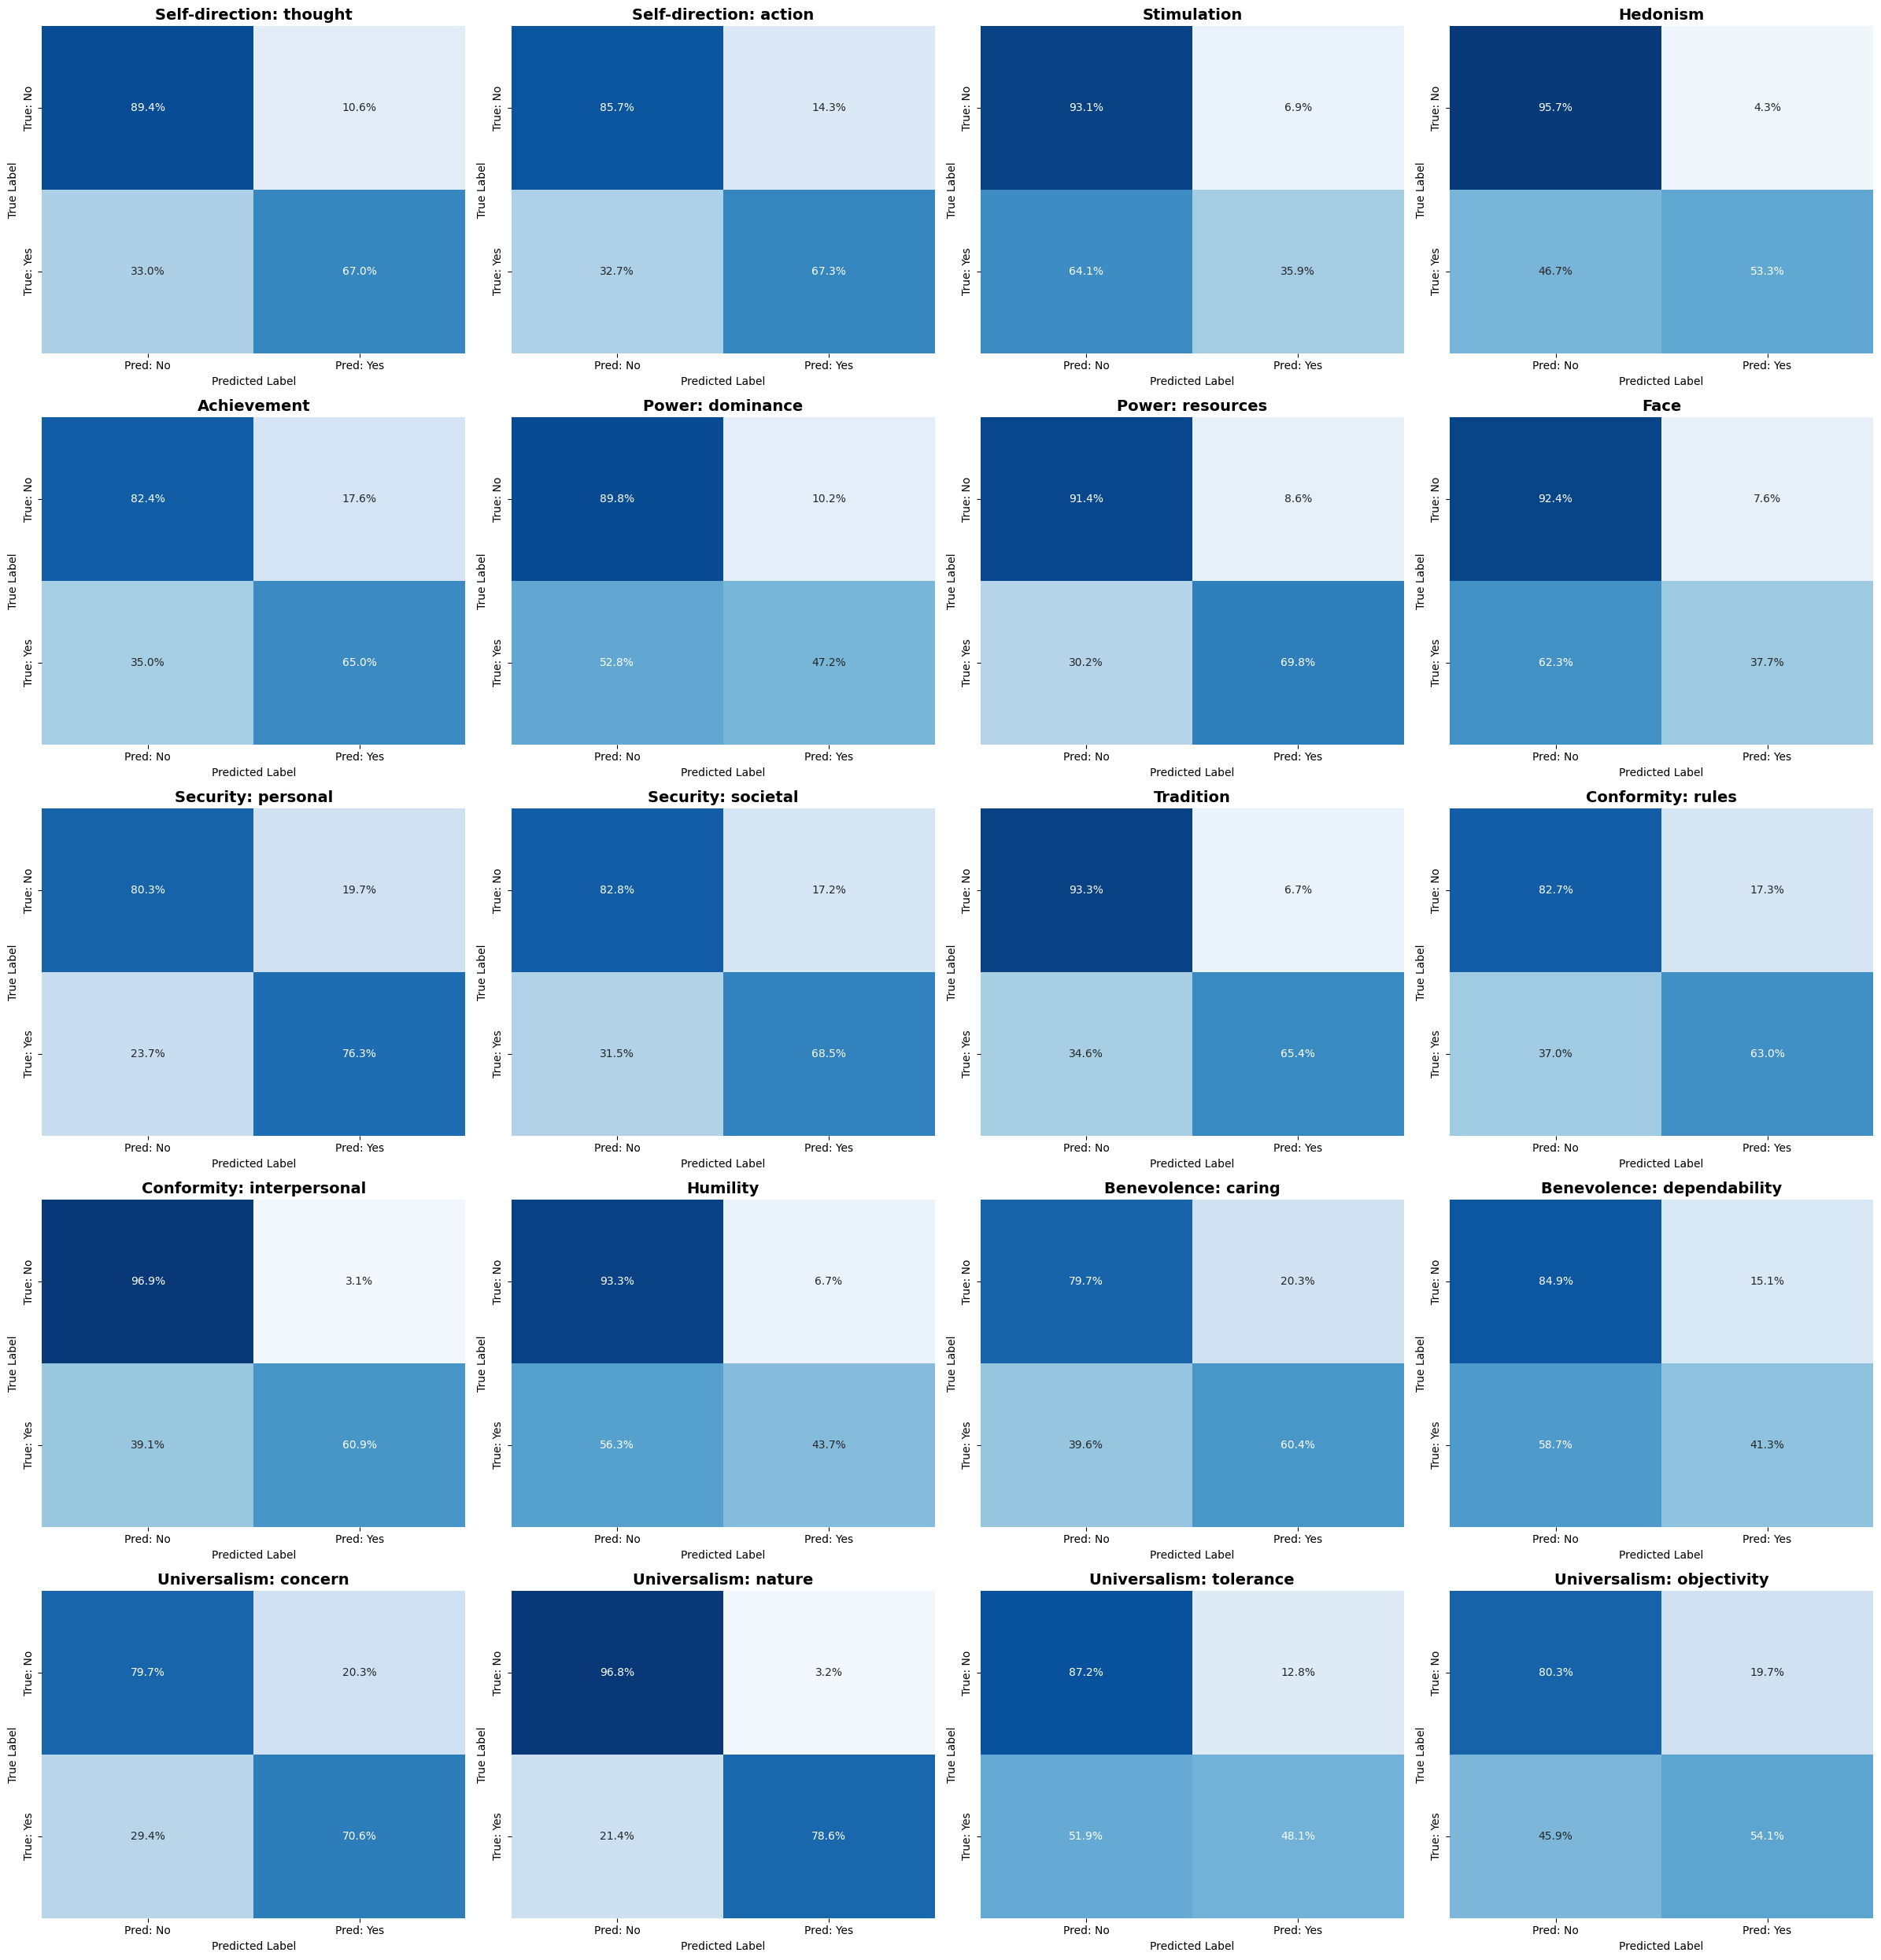

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import multilabel_confusion_matrix

# 1. Generate predictions
print("Generating predictions on the test set...")
y_pred = random_search.predict(X_test_lemmatized)

# 2. Compute matrices & setup plot
mcm = multilabel_confusion_matrix(y_test, y_pred)
class_names = [col for col in train_labels.columns if col != 'Argument ID']

num_classes = len(class_names)
cols = 4
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(24, 5 * rows))
axes = axes.flatten()

# 3. Plot normalized matrices
for i, (matrix, name) in enumerate(zip(mcm, class_names)):
    # Normalize by row (True Label) to show Recall vs Specificity
    # Add epsilon to prevent division by zero
    row_sums = matrix.sum(axis=1)[:, np.newaxis]
    normalized_matrix = matrix.astype('float') / (row_sums + 1e-10)

    sns.heatmap(normalized_matrix, annot=True, fmt='.1%', cmap='Blues', ax=axes[i],
                xticklabels=['Pred: No', 'Pred: Yes'], 
                yticklabels=['True: No', 'True: Yes'],
                cbar=False, vmin=0, vmax=1)
    
    axes[i].set_title(f'{name}', fontweight='bold', fontsize=14)
    axes[i].set_ylabel('True Label', fontsize=10)
    axes[i].set_xlabel('Predicted Label', fontsize=10)

# 4. Cleanup
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("confusion_matrices_normalized.png", dpi=400)
plt.show()

The confusion matrices reveal a strong class imbalance. The model performs well on concrete values like 'Security' and 'Universalism' (high True Positives), but struggles with abstract values like 'Stimulation' and 'Face', often defaulting to the majority class (predicting 'Negative')

## 4.2 Discriminative Features

In [22]:
import numpy as np

# 1. Extract pipeline components
best_pipeline = random_search.best_estimator_
vectorizer = best_pipeline.named_steps['vec']
ovr_model = best_pipeline.named_steps['clf']

# 2. Get vocabulary and models
feature_names = vectorizer.get_feature_names_out()
classifiers = ovr_model.estimators_

# 3. Class names (excluding ID)
class_names = [col for col in train_labels.columns if col != 'Argument ID']

# --- DIAGNOSTICS ---
print("⚙️ MODEL DIAGNOSTICS:")
print(f" - Number of features: {len(feature_names)}")
print(f" - Number of classifiers: {len(classifiers)}")
print("=" * 70)
# -------------------

print("\n🔍 EXTRACTING DISCRIMINATIVE FEATURES (TOP 10 N-GRAMS)")

# 4. Iterate through classifiers
for i in range(len(classifiers)):
    
    # Safe name assignment
    if i < len(class_names):
        class_name = class_names[i]
    else:
        class_name = f"Unknown_Class_{i}"
        
    # Get coefficients
    coefs = classifiers[i].coef_[0]
    
    # Sort indices by weight
    sorted_indices = np.argsort(coefs)
    
    # Extract top n-grams (Negative vs Positive)
    top_negative = [feature_names[idx] for idx in sorted_indices[:10]]
    top_positive = [feature_names[idx] for idx in sorted_indices[-10:]][::-1]
    
    print(f"\n🏆 CLASS: {class_name}")
    print(f"  🟢 POSITIVE (+): {', '.join(top_positive)}")
    print(f"  🔴 NEGATIVE (-): {', '.join(top_negative)}")

⚙️ MODEL DIAGNOSTICS:
 - Number of features: 20000
 - Number of classifiers: 20

🔍 EXTRACTING DISCRIMINATIVE FEATURES (TOP 10 N-GRAMS)

🏆 CLASS: Self-direction: thought
  🟢 POSITIVE (+): freedom, innovation, choice, exploration favor, research favor, research, uniform favor, express, speech, religion
  🔴 NEGATIVE (-): offence favor, burning favor, clone favor, cause, naturopathy favor, uniform school, reason, activism favor, ban favor, dangerous

🏆 CLASS: Self-direction: action
  🟢 POSITIVE (+): choice, freedom, want, retirement favor, right, selection favor, polygamy favor, independent, free, collectivism favor
  🔴 NEGATIVE (-): ban favor, minor favor, favor, offence favor, surgery favor, burning favor, naturopathy favor, arm favor, mandatory favor, law

🏆 CLASS: Stimulation
  🟢 POSITIVE (+): favor state, productive, country trade, abandon favor, various, make country, learn new, favor vow, urbanization, education good
  🔴 NEGATIVE (-): government, urbanization favor, favor television

### 🧠 Analysis: Why do "Bad" words predict "Good" values?

If you look at the top features for **Benevolence: caring**, you might see words like **"cheating"**, **"bullied"**, or **"con"**. This seems contradictory—why would *cheating* be a signal for *caring*?

This is a classic NLP phenomenon known as **"Values via Violation"**.

#### 1. The Logic of Violation
Human values are often invisible until they are threatened. We rarely write arguments saying *"I love caring for people."* Instead, we write arguments defending victims.
* **The Context:** To manifest the value of **Caring**, there usually needs to be a **Victim**.
* **The Correlation:** You cannot discuss a victim without discussing the perpetrator or the act (the "cheating").
* **The Model's Lesson:** The model learns that whenever the word `cheating` appears, the text is defending a victim, and therefore the label is `Benevolence`.

#### 2. The "Anti-Value" Signal
The Logistic Regression coefficients show **correlation**, not **definition**.
* **Security:** Often predicted by `war`, `terrorism`, or `attack` (the threat to security).
* **Tradition:** Often predicted by `modern`, `destroy`, or `lost` (the threat to tradition).
* **Caring:** Predicted by `suffering`, `harm`, and `cheating`.

**Key Takeaway:** The model isn't saying "Cheating is good." It is saying, *"When people talk about cheating, they are usually appealing to your sense of caring."*

## 4.3 Qualitative Failure Analysis

Qualitative Failure Analysis: Manual categorization of at least 5 specific misclassified examples (e.g., sarcasm, negation failure, ambiguity).

In [23]:
import numpy as np

# 1. Find indices with AT LEAST ONE ERROR (False Positive or False Negative)
# Compare row by row
error_indices = np.where(np.any(y_test != y_pred, axis=1))[0]

print(f"Total texts with at least one error: {len(error_indices)}")
print("Showing 5 random failure examples for Qualitative Analysis:\n")

# 2. Pick 5 random indices (fixed seed for reproducibility)
np.random.seed(42)
sample_indices = np.random.choice(error_indices, 5, replace=False)

# 3. Print original text and the failure details
for i, idx in enumerate(sample_indices):
    # Use X_test (original text list) for readability
    original_text = X_test[idx]
    
    # Get Ground Truth labels (Human Annotations)
    true_labels_list = [class_names[j] for j, val in enumerate(y_test[idx]) if val == 1]
    
    # Get Predicted labels (Model)
    pred_labels_list = [class_names[j] for j, val in enumerate(y_pred[idx]) if val == 1]
    
    print("=" * 80)
    print(f"❌ FAILURE EXAMPLE #{i+1}")
    print("-" * 80)
    print(f"📝 ORIGINAL TEXT:\n{original_text}\n")
    
    print(f"🧠 TRUE LABELS (Annotators): {true_labels_list if true_labels_list else 'None'}")
    print(f"🤖 PREDICTED LABELS (Model):  {pred_labels_list if pred_labels_list else 'None'}")
    print("=" * 80 + "\n")

Total texts with at least one error: 1680
Showing 5 random failure examples for Qualitative Analysis:

❌ FAILURE EXAMPLE #1
--------------------------------------------------------------------------------
📝 ORIGINAL TEXT:
We should legalize polygamy against we shouldn't legalize polygamy because it will lead to more abusive relationships

🧠 TRUE LABELS (Annotators): ['Security: societal', 'Conformity: rules', 'Universalism: concern', 'Universalism: objectivity']
🤖 PREDICTED LABELS (Model):  ['Tradition', 'Conformity: rules', 'Benevolence: caring']

❌ FAILURE EXAMPLE #2
--------------------------------------------------------------------------------
📝 ORIGINAL TEXT:
We should oppose collectivism in favor of collectivism does not allow one person to stand out from the others, which can be negative

🧠 TRUE LABELS (Annotators): ['Self-direction: action', 'Stimulation', 'Achievement', 'Power: dominance', 'Face']
🤖 PREDICTED LABELS (Model):  ['Self-direction: thought', 'Self-direction: actio